In [3]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(0)

In [64]:
class Dataloader():
    """ Loads the data, gives list of annotations and also provide a sample image """
    def __init__(self,filename):
        self.filename=filename

    def list_of_annotations(self):
        clothing = []
        with open(self.filename) as f:
            for line in f:
                clothing.append(json.loads(line))
        return clothing

    def get_categories(self):
        categories = []
        for c in self.list_of_annotations():
            for a in c['annotation']:
                categories.extend(a['label'])
        categories = list(set(categories))
        categories.sort()
        return categories

    def save_sample(self,name,number):
        row = self.list_of_annotations()[number]

        img = urllib.request.urlopen(row["content"])
        img = Image.open(img)
        img = img.convert('RGB')

        img.save( f"{name}.jpeg", "JPEG")
        print("Image Saved")


In [91]:
d1=Dataloader("clothing.json")
annotation_list=d1.list_of_annotations()

In [92]:
annotation_list[0]

{'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/4bb8fd9d-8d52-46c7-aa2a-9c18af10aed6___Data_xxl-top-4437-jolliy-original-imaekasxahykhd3t.jpeg',
 'annotation': [{'label': ['Tops'],
   'notes': '',
   'points': [{'x': 0.02040816326530612, 'y': 0.2532051282051282},
    {'x': 0.9931972789115646, 'y': 0.8108974358974359}],
   'imageWidth': 147,
   'imageHeight': 312}],
 'extras': None}

In [99]:
categories=d1.get_categories()
lis=[]
for category in categories:
    category=category[:-1]
    lis.append(category)
categories=lis
categories

['Jacket',
 'Jean',
 'Shirt',
 'Shoe',
 'Skirt',
 'Top',
 'Trouser',
 'Tshirt',
 'sunglasse']

In [42]:
d1.save_sample("demo_image",79)

Image Saved


In [43]:
img = cv2.cvtColor(cv2.imread(f'demo_image.jpeg'), cv2.COLOR_BGR2RGB)
img.shape

(312, 154, 3)

In [101]:
train_clothing, val_clothing = train_test_split(annotation_list, test_size=0.1,shuffle=True)
len(train_clothing),len(val_clothing)

(453, 51)

In [102]:
class ProcessImage(dataloader): #Inheritance
    """ Add bounding box to the image """
    def __init__(self,clothing):
        self.clothing=clothing

    def __call__(self,sample,img): #Function Overloading. Class can be used as a function
        for a in sample['annotation']:
            for label in a['label']:
                w = a['imageWidth']
                h = a['imageHeight']

        points = a['points']
        p1, p2 = points

        x1, y1 = p1['x'] * w, p1['y'] * h
        x2, y2 = p2['x'] * w, p2['y'] * h

        cv2.rectangle(
            img,
            (int(x1), int(y1)),
            (int(x2), int(y2)),
            color=(0, 255, 0),
            thickness=2
        )

        ((label_width, label_height), _) = cv2.getTextSize(
            label, 
            fontFace=cv2.FONT_HERSHEY_PLAIN,
            fontScale=1.75, 
            thickness=2
        )

        cv2.rectangle(
            img,
            (int(x1), int(y1)),
            (int(x1 + label_width + label_width * 0.05), int(y1 + label_height + label_height * 0.25)),
            color=(0, 255, 0),
            thickness=cv2.FILLED
        )

        cv2.putText(
            img,
            label,
            org=(int(x1), int(y1 + label_height + label_height * 0.25)), # bottom left
            fontFace=cv2.FONT_HERSHEY_PLAIN,
            fontScale=1.75,
            color=(255, 255, 255),
            thickness=2
        )


Image Saved


(-0.5, 180.5, 311.5, -0.5)

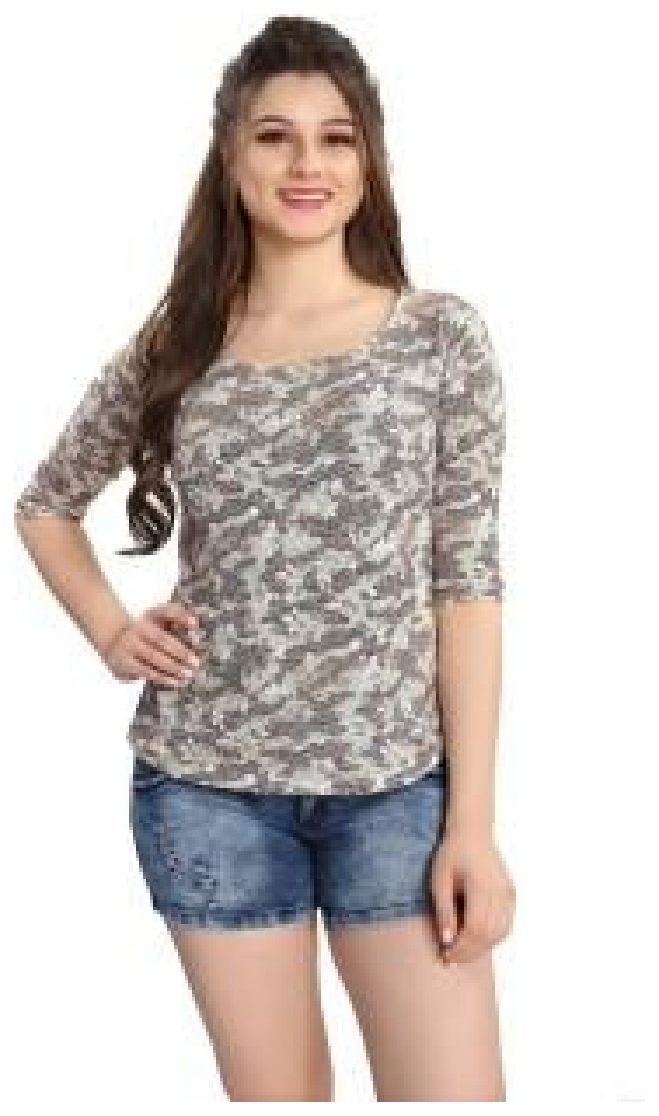

In [103]:
d1.save_sample("demo_image",21)
img = cv2.cvtColor(cv2.imread(f'demo_image.jpeg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")

(-0.5, 180.5, 311.5, -0.5)

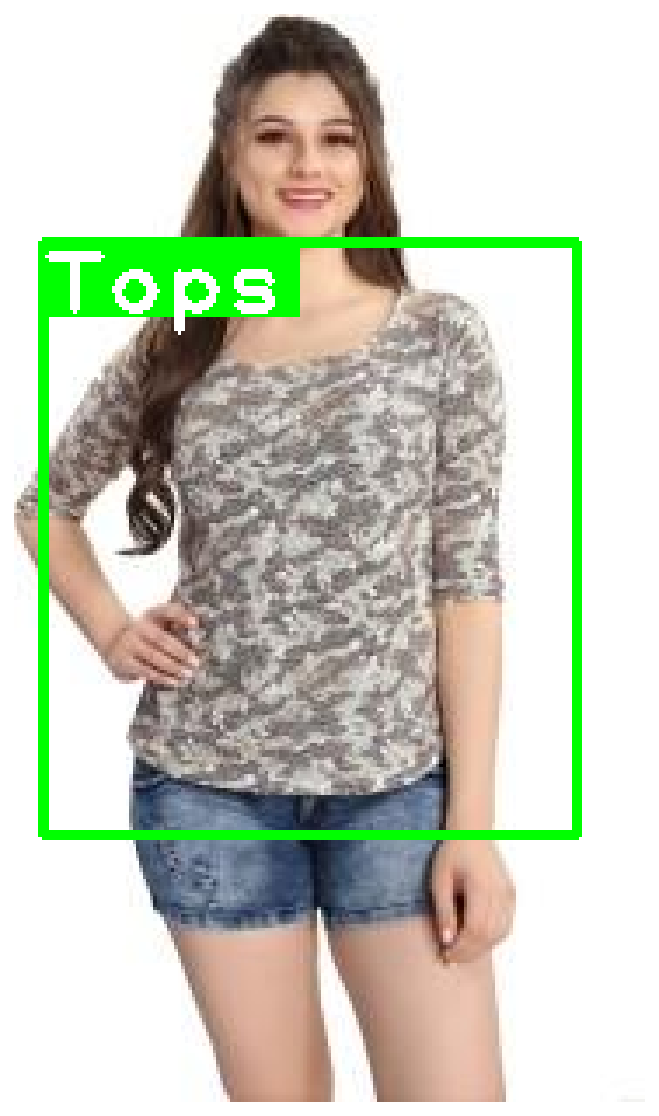

In [104]:
sample=annotation_list[21]
p1=ProcessImage(annotation_list)
p1(sample,img)
plt.imshow(img)
plt.axis("off")

In [58]:
class Convert_To_Yolo():
    def __init__(self,clothing, categories, dataset_type):
        self.clothing=clothing
        self.categories=categories
        self.dataset_type=dataset_type

    def createdataset(self):
        images_path = Path(f"clothing/images/{self.dataset_type}")
        images_path.mkdir(parents=True, exist_ok=True)

        labels_path = Path(f"clothing/labels/{self.dataset_type}")
        labels_path.mkdir(parents=True, exist_ok=True)

        for img_id, row in enumerate(tqdm(self.clothing)):

            image_name = f"{img_id}.jpeg"

            img = urllib.request.urlopen(row["content"])
            img = Image.open(img)
            img = img.convert("RGB")

            img.save(str(images_path / image_name), "JPEG")

            label_name = f"{img_id}.txt"

            with (labels_path / label_name).open(mode="w") as label_file:

                for a in row['annotation']:

                    for label in a['label']:

                        category_idx = categories.index(label)

                        points = a['points']
                        p1, p2 = points

                        x1, y1 = p1['x'], p1['y']
                        x2, y2 = p2['x'], p2['y']

                        bbox_width = x2 - x1
                        bbox_height = y2 - y1

                        label_file.write(
                          f"{category_idx} {x1 + bbox_width / 2} {y1 + bbox_height / 2} {bbox_width} {bbox_height}\n"
                        )

In [70]:
trainset=Convert_To_Yolo(train_clothing, categories, 'train')
testset=Convert_To_Yolo(val_clothing, categories, 'val')

In [71]:
trainset.createdataset()
testset.createdataset()

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:36<00:00,  1.40it/s]


In [72]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

D:\3rd sem\OOP PROJECT\content\yolov5


Cloning into 'yolov5'...


In [74]:
!python detect.py --weights weights/best.pt --conf 0.4 --source inference/images/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='inference/images/', update=False, view_img=False, weights=['weights/best.pt'])
Fusing layers... 
image 1/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\20.jpeg: 640x320 1 Skirtss, Done. (2.129s)
image 2/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\21.jpeg: 640x416 1 Tshirtss, Done. (0.338s)
image 3/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\22.jpeg: 640x384 1 Jeanss, Done. (0.301s)
image 4/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\23.jpeg: 384x640 1 Shoess, Done. (0.301s)
image 5/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\24.jpeg: 640x288 1 Topss, Done. (0.254s)
image 6/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\25.jpeg: 640x480 1 Trouserss, Done. (0.348s)
image 7/50 D:\3rd sem\OOP PROJECT\content\

Using torch 1.6.0 CUDA:0 (GeForce 940MX, 2048MB)

Model Summary: 484 layers, 88444446 parameters, 0 gradients



image 31/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\50.jpeg: 640x384 1 Trouserss, Done. (0.301s)
image 32/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\51.jpeg: 416x640 1 sunglassess, Done. (0.348s)
image 33/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\52.jpeg: 640x352 1 Shirtss, Done. (0.279s)
image 34/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\53.jpeg: 640x448 1 Jacketss, Done. (0.339s)
image 35/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\54.jpeg: 640x480 1 Jeanss, Done. (0.354s)
image 36/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\55.jpeg: 640x448 1 Jacketss, Done. (0.332s)
image 37/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\56.jpeg: 640x352 1 Shirtss, Done. (0.300s)
image 38/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\57.jpeg: 640x512 1 Skirtss, Done. (0.370s)
image 39/50 D:\3rd sem\OOP PROJECT\content\yolov5\inference\images\58.jpeg: 640x288 1 Topss, Done. (0.270s)
imag

In [75]:
class HelperClass():
    @staticmethod
    def load_image(img_path: Path, resize=True):
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 256), interpolation = cv2.INTER_AREA)
        return img
    @staticmethod
    def show_grid(image_paths):
        images = [HelperClass.load_image(img) for img in image_paths]
        images = torch.as_tensor(images)
        images = images.permute(0, 3, 1, 2)
        grid_img = torchvision.utils.make_grid(images, nrow=11)
        plt.figure(figsize=(24, 12))
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.axis('off');

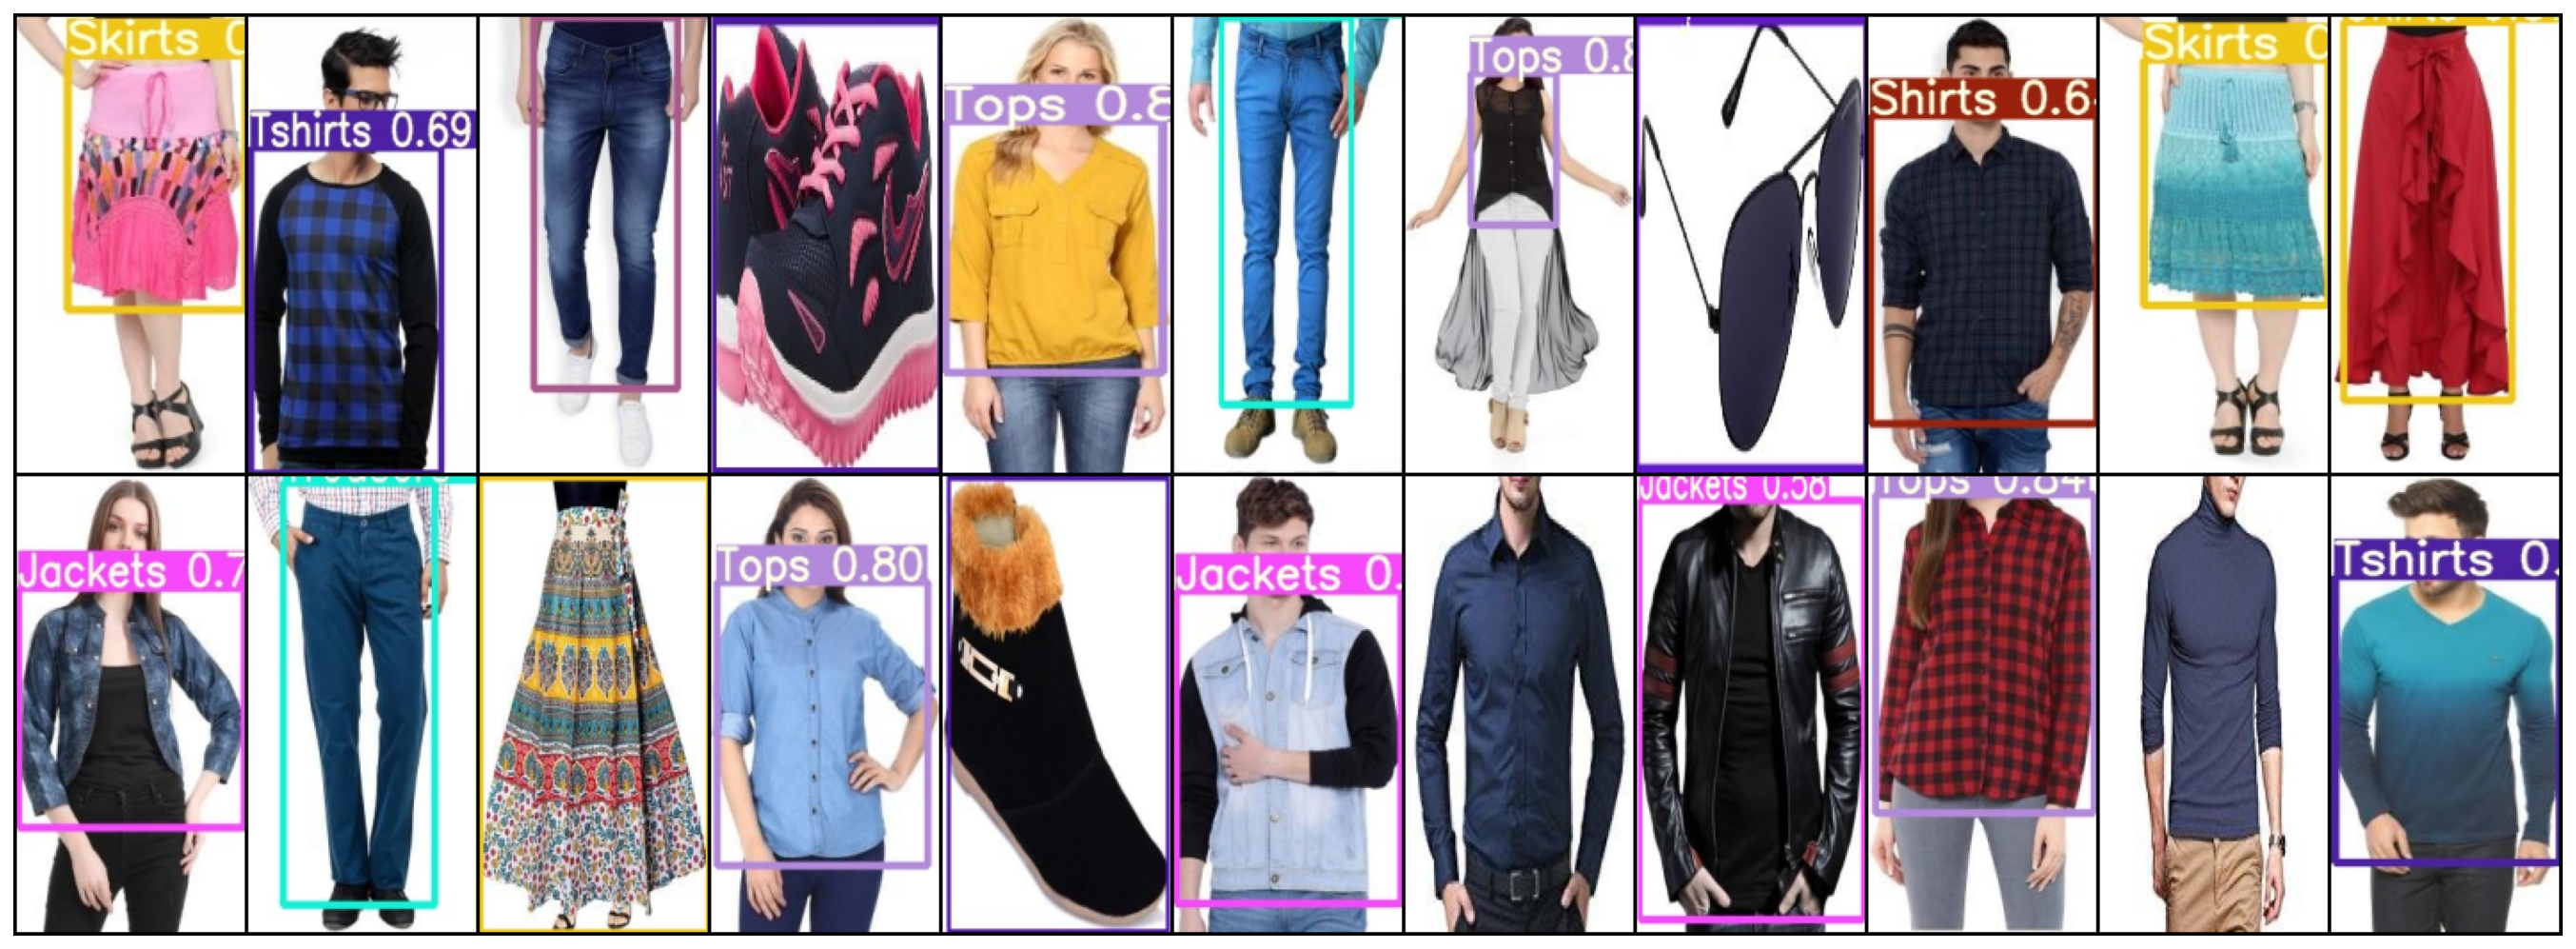

In [77]:
img_paths = list(Path("runs/detect/exp").glob("*.jpeg"))[:22]
HelperClass.show_grid(img_paths)

In [78]:
!python detect.py --weights weights/best.pt --conf 0.4 --source data/images/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='data/images/', update=False, view_img=False, weights=['weights/best.pt'])
Fusing layers... 
image 1/2 D:\3rd sem\OOP PROJECT\content\yolov5\data\images\bus.jpg: 640x480 1 Shoess, Done. (0.363s)
image 2/2 D:\3rd sem\OOP PROJECT\content\yolov5\data\images\zidane.jpg: 384x640 Done. (0.301s)
Results saved to runs\detect\exp2
Done. (2.524s)


Using torch 1.6.0 CUDA:0 (GeForce 940MX, 2048MB)

Model Summary: 484 layers, 88444446 parameters, 0 gradients


In [108]:
!python detect.py --weights weights/best.pt --img 320 --source 0

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=320, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='0', update=False, view_img=False, weights=['weights/best.pt'])
Fusing layers... 
1/1: 0...  success (640x480 at 30.00 FPS).


Using torch 1.6.0 CUDA:0 (GeForce 940MX, 2048MB)

Model Summary: 484 layers, 88444446 parameters, 0 gradients



0: 256x320 1 Tshirtss, Done. (1.829s)
0: 256x320 1 Tshirtss, Done. (0.115s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.115s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.125s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Shirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.121s)
0: 256x320 1

0: 256x320 Done. (0.120s)
0: 256x320 Done. (0.115s)
0: 256x320 Done. (0.110s)
0: 256x320 Done. (0.121s)
0: 256x320 Done. (0.120s)
0: 256x320 Done. (0.120s)
0: 256x320 Done. (0.110s)
0: 256x320 Done. (0.120s)
0: 256x320 Done. (0.110s)
0: 256x320 Done. (0.120s)
0: 256x320 Done. (0.110s)
0: 256x320 Done. (0.110s)
0: 256x320 Done. (0.110s)
0: 256x320 Done. (0.110s)
0: 256x320 Done. (0.120s)
0: 256x320 1 Shoess, Done. (0.120s)
0: 256x320 1 Shoess, Done. (0.120s)
0: 256x320 1 Shoess, Done. (0.120s)
0: 256x320 1 Shoess, Done. (0.115s)
0: 256x320 1 Shoess, Done. (0.120s)
0: 256x320 1 Tshirtss, Done. (0.120s)
0: 256x320 Done. (0.120s)
0: 256x320 Done. (0.120s)
0: 256x320 Done. (0.110s)
0: 256x320 1 Shoess, Done. (0.120s)
0: 256x320 Done. (0.120s)
0: 256x320 Done. (0.115s)
0: 256x320 1 Topss, Done. (0.120s)
0: 256x320 1 Topss, Done. (0.120s)
0: 256x320 1 Topss, Done. (0.120s)
0: 256x320 Done. (0.119s)
0: 256x320 Done. (0.115s)
0: 256x320 Done. (0.120s)
0: 256x320 Done. (0.120s)
0: 256x320 Done. 

In [106]:
%cd yolov5
    


D:\3rd sem\OOP PROJECT\content\yolov5
